In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import math, random, copy

In [2]:
# ランドマークを描画する関数
def draw_landmarks(landmarks):
    xs = [e[0] for e in landmarks]
    ys = [e[1] for e in landmarks]
    plt.scatter(xs,ys,s=300,marker="*",label="landmarks",color="orange")

In [3]:
# ランドマークとロボットとの距離と角度を計算する関数
def relative_landmark_pos(pose,landmark):
    x,y,theta = pose
    lx,ly = landmark
    distance = math.sqrt((x-lx)**2 + (y-ly)**2)
    direction = math.atan2(ly-y, lx-x) - theta
    
    return (distance,direction,lx,ly) 

# ランドメークへの距離と角度を描画する関数
def draw_observation(pose, measurement):
    x,y,theta = pose
    mdistance,mdirection,tmp_x,tmp_y = measurement
    
    lx = mdistance*math.cos(theta + mdirection) + x
    ly = mdistance*math.sin(theta + mdirection) + y
    plt.plot([pose[0], lx],[pose[1], ly],color="black")

# 全てのランドマークに対して
def draw_observations(pose, measurements):
    for m in measurements:
        draw_observation(pose, m)

In [4]:
# 範囲の制限と雑音の追加を加える関数
def observation(pose, landmark):
    adistance,adirection,lx,ly = relative_landmark_pos(pose,landmark)
    
    # cosの値が正．つまり左右90度
    if math.cos(adirection) < 0.0:
        return None
    
    mdistance = random.gauss(adistance,adistance*0.1)
    mdirection = random.gauss(adirection,math.pi/180 * 5.0)
    
    return (mdistance,mdirection,lx,ly)

# 全ランドマークで
def observations(pose,landmarks):
    ms = []
    for ln in landmarks:
        m = observation(pose,ln)
        if m != None:
            ms.append(m)
    return ms
 #   return filter(lambda x:x != None, [obsevation(pose, e) for e in landmarks])

In [5]:
# パーティクルを作成
class Particle:
    def __init__(self,p,w):
        self.pose = p # パーティクルの位置、向き
        self.weight = w #このパーティクルがどれだけ重要か
    
    def __repr__(self):
        return "pose: " + str(self.pose) + " weight: " + str(self.weight)

# 状態方程式
def f(x_old,u):
    pos_x, pos_y, pos_theta = x_old
    act_fw, act_rot = u
    
    act_fw = random.gauss(act_fw,act_fw/10)
    dir_error = random.gauss(0.0, math.pi / 180.0 * 3.0)
    act_rot = random.gauss(act_rot,act_rot/10)
    
    pos_x += act_fw * math.cos(pos_theta + dir_error)
    pos_y += act_fw * math.sin(pos_theta + dir_error)
    pos_theta += act_rot
    
    return np.array([pos_x,pos_y,pos_theta])

# ロボットとパーティクルの描画
def draw(pose,particles): # ロボットの位置姿勢，パーティクル100個の位置姿勢
    fig = plt.figure(i,figsize=(8,8))
    sp = fig.add_subplot(111,aspect='equal')
    sp.set_xlim(-1.0,1.0)
    sp.set_ylim(-0.5,1.5)
    
    # パーティクルの描画
    xs = [ e.pose[0] for e in particles ]
    ys = [ e.pose[1] for e in particles ]
    vxs = [math.cos(e.pose[2])*e.weight for e in particles ]
    vys = [math.sin(e.pose[2])*e.weight for e in particles ]
    plt.quiver(xs,ys,vxs,vys,color="blue")
    
    # 実際のロボットの描画
    plt.quiver([pose[0]],[pose[1]],[math.cos(pose[2])],[math.sin(pose[2])],color="red",label="actual robot motion")

In [6]:
# パーティクルの姿勢と観測結果を比較する関数
def likelihood(pose, measurement):
    x,y,theta = pose
    distance, direction,lx,ly = measurement
    
    # パーティクルの姿勢から観測されるはずのランドマークの距離と向き
    rel_distance, rel_direction, tmp_x, tmp_y = relative_landmark_pos(pose,(lx,ly))
    
    # 誤差をガウスで評価
    return norm.pdf(x = distance - rel_distance, loc = 0.0, scale = rel_distance / 10.0)  \
             * norm.pdf(x = direction - rel_direction, loc = 0.0, scale = 5.0/180.0 * math.pi)

# パーティクル群の重みを変更する関数
def change_weights(particles, measurement):
    for p in particles:
        p.weight *= likelihood(p.pose, measurement)
        
    ws = [p.weight for p in particles]
    s = sum(ws)
    for p in particles: p.weight = p.weight / s

In [7]:
# リサンプリングする関数
def resampling(particles):
    accum = []
    sm = 0.0
    for p in particles:
        sm += p.weight 
        accum.append(sm)

    pointer = random.uniform(0.0,1.0/len(particles))

    new_particles = []
    particles_num = len(particles)

    while pointer < 1.0: # ポインタ数が一未満の間繰り返す
        if accum[0] >= pointer: # リストの先頭の確率がポインタ数以上なら
            new_particles.append(
                Particle(copy.deepcopy(particles[0].pose),1.0/particles_num)
            )
            pointer += 1.0/particles_num
        else:
            accum.pop(0)
            particles.pop(0)
        
    particles = new_particles
    
    return particles

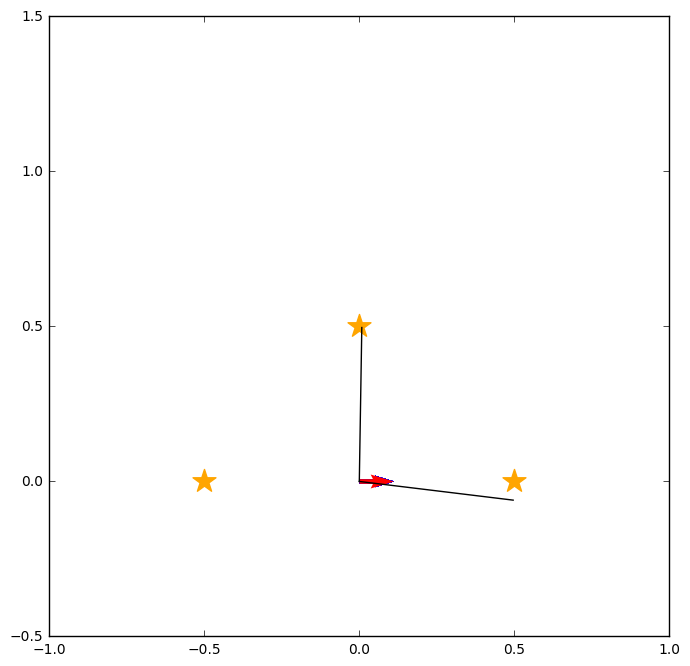

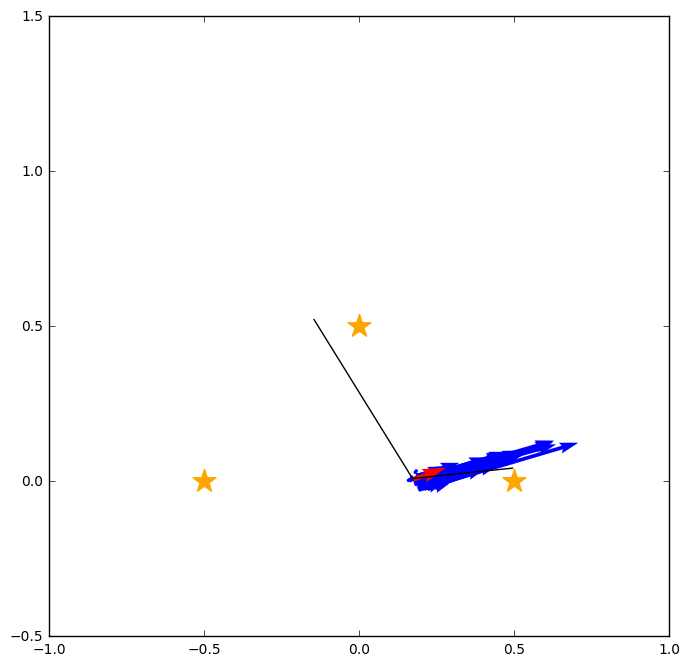

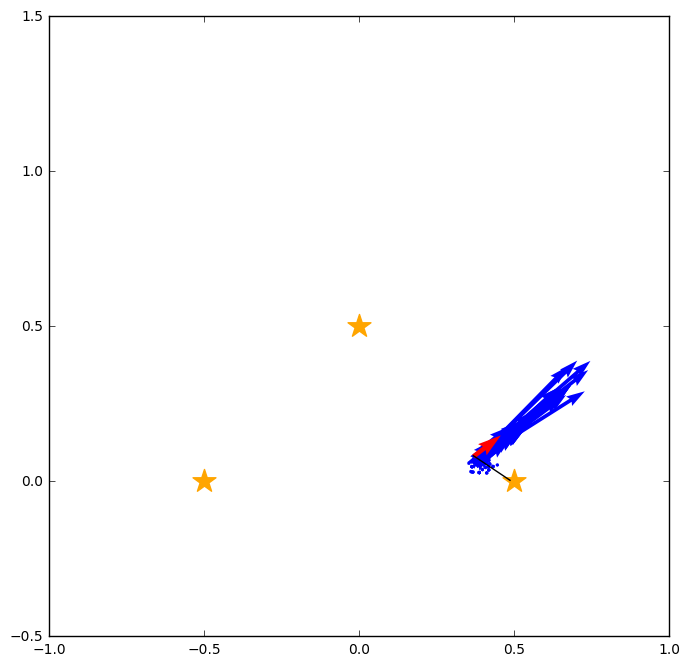

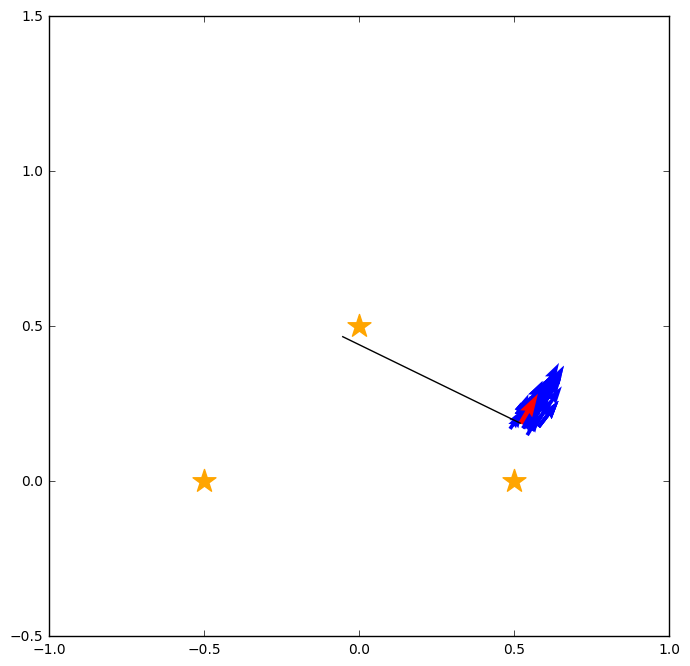

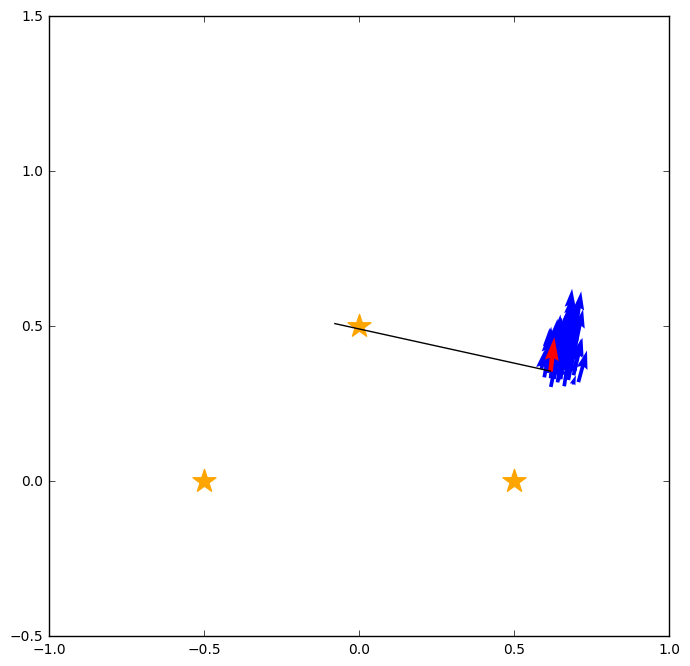

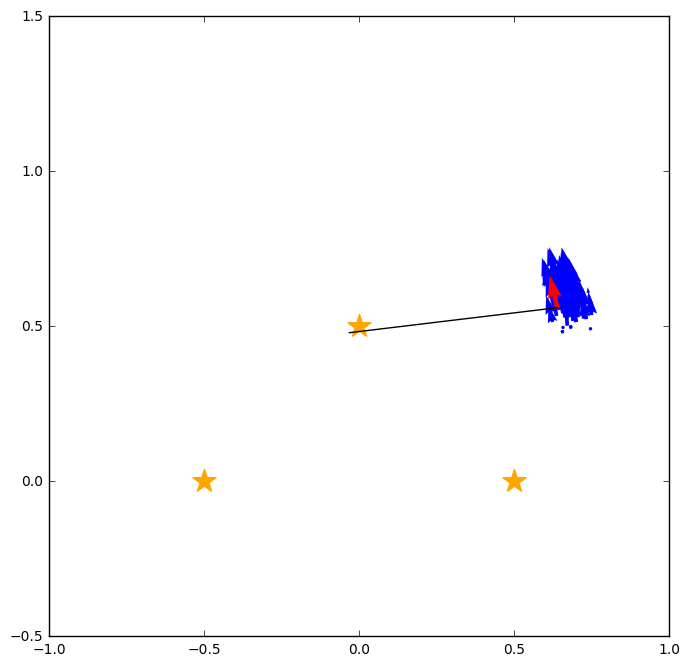

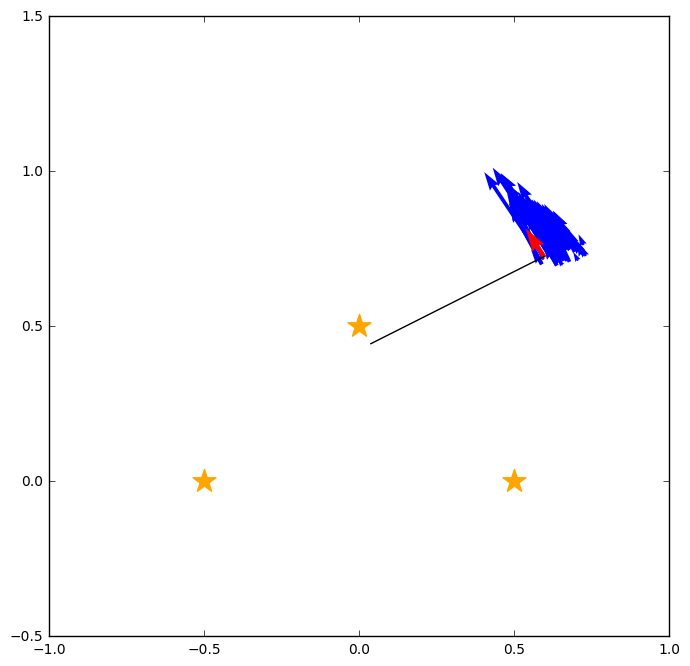

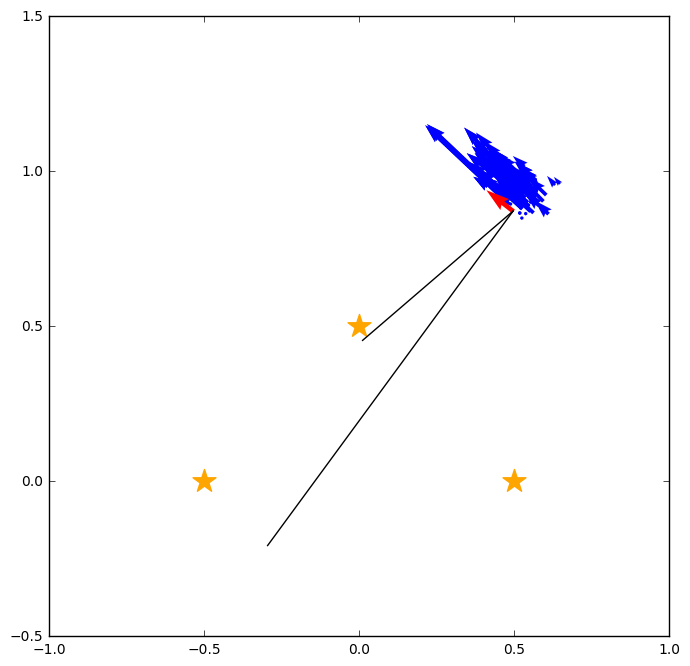

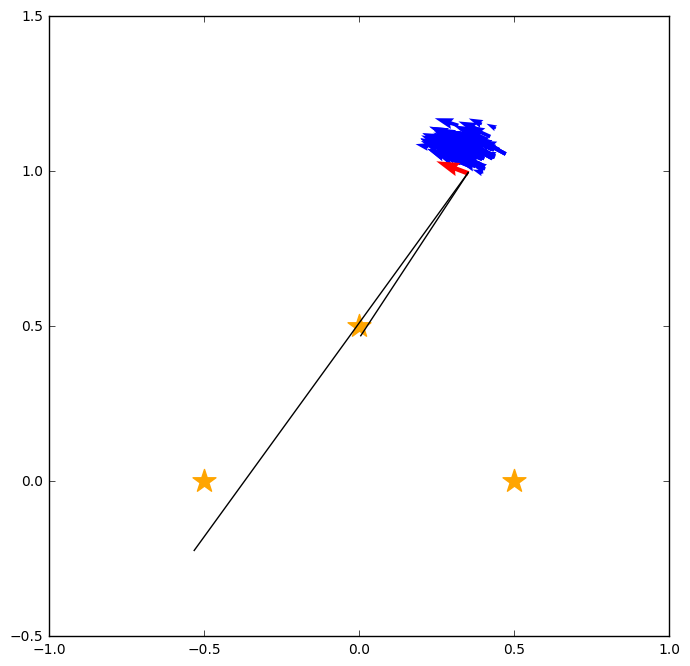

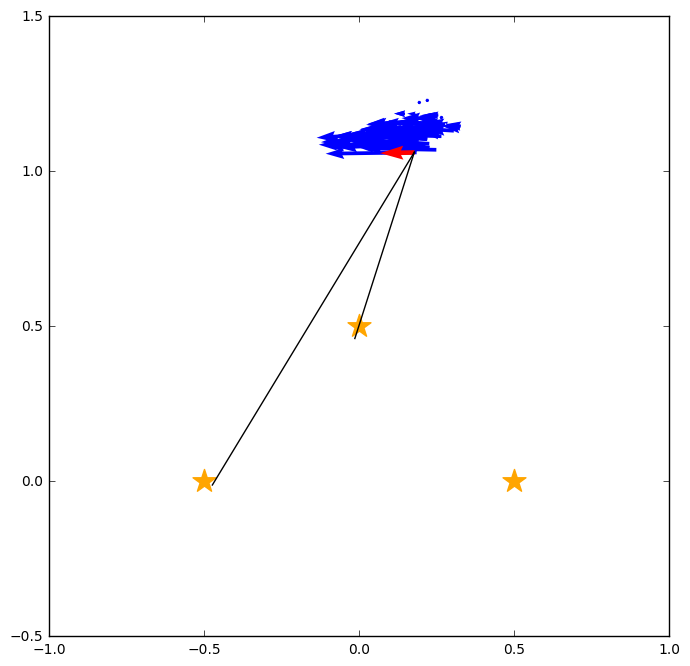

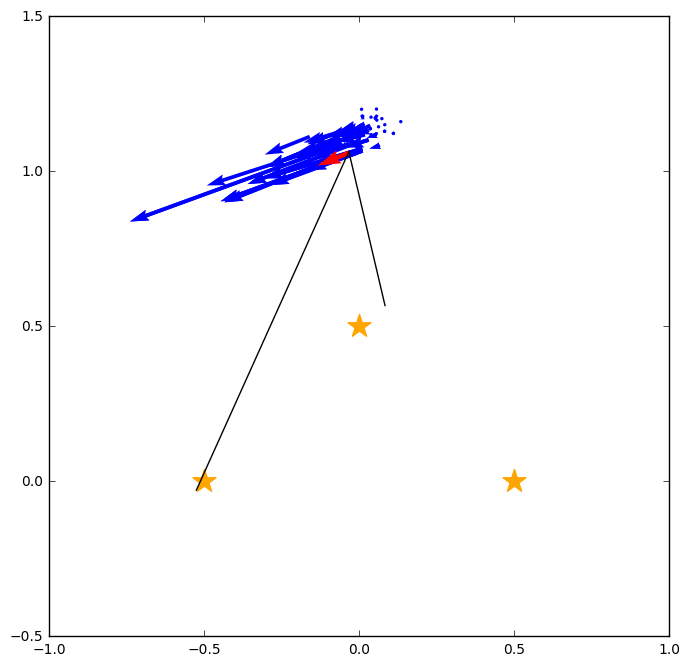

In [8]:
actual_x = np.array([0.0, 0.0, 0.0]) # ロボットの姿勢
particles = [Particle(actual_x,1.0/100) for i in range(100)] # 重み0.01のパーティクル100個
u  = np.array([0.2,math.pi/180.0*20]) # ロボットの移動
actual_landmarks = [np.array([-0.5,0.0]), np.array([0.5,0.0]), np.array([0.0,0.5])] # ランドマークの位置

path = [actual_x]
particle_path = [copy.deepcopy(particles)]
measurements = [observations(actual_x, actual_landmarks)]

for i in range(10):
    # ロボットの姿勢10回分
    actual_x = f(actual_x,u)
    path.append(actual_x)
    ms = observations(actual_x,actual_landmarks)
    measurements.append(ms)
    
    # パーティクルの姿勢100個分
    for p in particles:
        p.pose = f(p.pose,u)
        
    particles = resampling(particles)
    
    # 重みの変更
    for m in ms:
        change_weights(particles, m)
    particle_path.append(copy.deepcopy(particles))

# ロボット，パーティクル，センサ，ランドマークの描画
for i,p in enumerate(path):
    draw(path[i],particle_path[i])
    draw_landmarks(actual_landmarks)
    draw_observations(path[i],measurements[i])